#**Question 2**

#Section 2-1 - Load and preprocess dataset

In [89]:
!git clone https://github.com/dml-qom/FarsTail.git
!pip install datasets

fatal: destination path 'FarsTail' already exists and is not an empty directory.


In [90]:
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
from datasets import Dataset

from transformers import BertConfig, BertTokenizer, BertModel

In [91]:
import pandas as pd

train_data = pd.read_csv('FarsTail/data/Train-word.csv', sep='\t')
val_data = pd.read_csv('FarsTail/data/Val-word.csv', sep='\t')
test_data = pd.read_csv('FarsTail/data/Test-word.csv', sep='\t')

In [92]:
train_data

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c
...,...,...,...
7261,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,تعداد فصول قانون اساسی ۱۴ و تعداد اصول آن ۱۷۷ ...,e
7262,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,قانون اساسی دارای ۲۵ فصل و ۱۷۵ اصل می باشد.,c
7263,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,در ۲۴ آبان ۵۸ کار تدوین قانون اساسی به پایان ر...,n
7264,محاصره اقتصادی پیامبر (ص) و یارانش که در سال ه...,حضرت محمد (ص) و یارانش از ششمین سال بعثت تا هش...,c


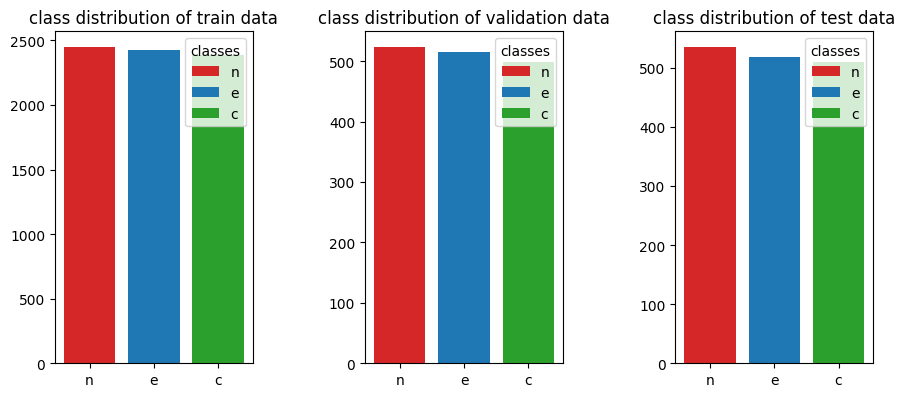

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(10, 5))
fig.tight_layout(pad=5.0)
bar_colors = ['tab:red', 'tab:blue', 'tab:green']

def class_distribution(df,text,index):
  labels = list(set(df['label']))
  keys = []
  values = []
  for l in labels:
    data = df[df['label'] == l]
    keys.append(l)
    values.append(len(data))
  ax[index].bar(keys, values, label=keys, color=bar_colors)
  ax[index].set_title('class distribution of ' + text + ' data')
  ax[index].set_title('class distribution of ' + text + ' data')
  ax[index].legend(title='classes')


class_distribution(train_data,'train',0)

class_distribution(val_data,'validation',1)

class_distribution(test_data, 'test',2)

plt.show()

In [94]:
from transformers import AutoConfig, AutoTokenizer, AutoModel

config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد می‌توانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenizer.tokenize(text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['ما',
 'در',
 'هوش',
 '##واره',
 'معتقدیم',
 'با',
 'انتقال',
 'صحیح',
 'دانش',
 'و',
 'اگاهی',
 '،',
 'همه',
 'افراد',
 'میتوانند',
 'از',
 'ابزارهای',
 'هوشمند',
 'استفاده',
 'کنند',
 '.',
 'شعار',
 'ما',
 'هوش',
 'مصنوعی',
 'برای',
 'همه',
 'است',
 '.']

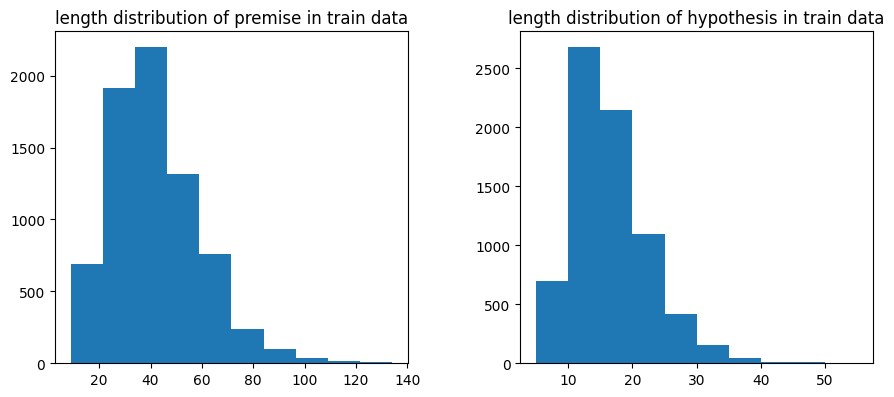

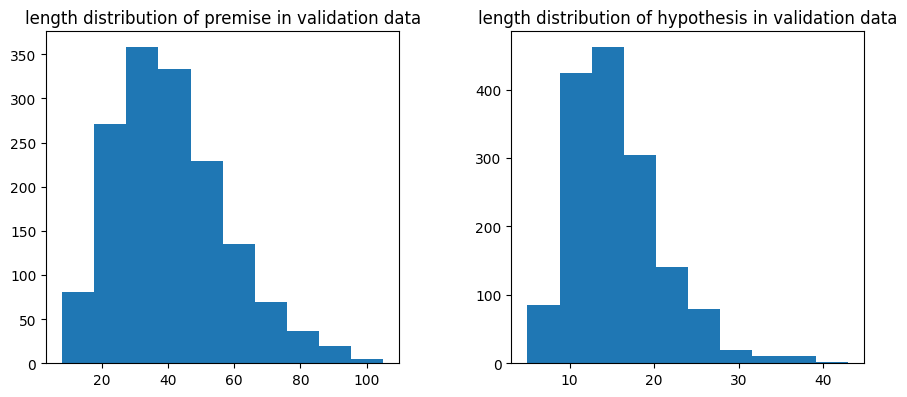

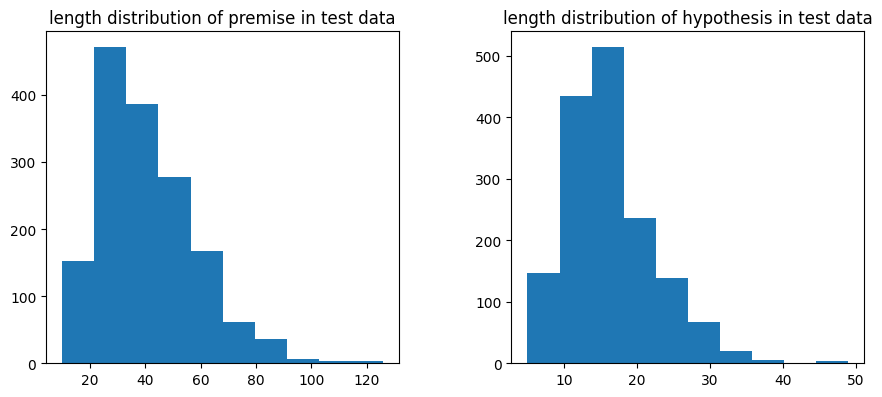

In [95]:
def length_dist(df,text):
  fig, ax = plt.subplots(1,2,figsize=(10, 5))
  fig.tight_layout(pad=5.0)
  premise = df['premise'].apply(lambda x: len(tokenizer.tokenize(x)))
  hypothesis = df['hypothesis'].apply(lambda x: len(tokenizer.tokenize(x)))
  ax[0].hist(premise)
  ax[0].set_title('length distribution of premise in ' + text + ' data')
  ax[1].hist(hypothesis)
  ax[1].set_title('length distribution of hypothesis in ' + text + ' data')
  plt.show()

length_dist(train_data,'train')
length_dist(val_data,'validation')
length_dist(test_data,'test')

In [96]:
!pip install hazm
!pip install nltk

In [97]:
import re
from string import punctuation
# from hazm import Normalizer
# from hazm import Stemmer, Lemmatizer

# stemmer = Stemmer()
# normalizer = Normalizer()
# lemmatizer = Lemmatizer()

def clean_text(text):
  text = re.sub(f'[{punctuation}؟،٪×÷»«]+','',text)
  # text = normalizer.normalize(text)
  # text = stemmer.stem(text)
  # text = lemmatizer.lemmatize(text)

  return text

train_data['hypothesis'] = train_data['hypothesis'].apply(lambda x: clean_text(x))
train_data['premise'] = train_data['premise'].apply(lambda x: clean_text(x))

val_data['hypothesis'] = val_data['hypothesis'].apply(lambda x: clean_text(x))
val_data['premise'] = val_data['premise'].apply(lambda x: clean_text(x))

test_data['hypothesis'] = test_data['hypothesis'].apply(lambda x: clean_text(x))
test_data['premise'] = test_data['premise'].apply(lambda x: clean_text(x))

In [98]:
from transformers import BertTokenizer
import torch
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-uncased', do_lower_case=True)

In [99]:
def add_special_token(data_record):
  tokens_premise = list(tokenizer.tokenize(str(data_record['premise'])))
  tokens_premise.append('[SEP]')
  tokens_hypothesis = list(tokenizer.tokenize(str(data_record['hypothesis'])))
  tokens_hypothesis.append('[SEP]')
  tokens = ['[CLS]']
  tokens.extend(tokens_premise)
  tokens.extend(tokens_hypothesis)
  return (' '.join(tokens))

final = []
for i,r in train_data.iterrows():
  final.append(add_special_token(r))

train_data['final'] = final

final = []
for i,r in val_data.iterrows():
  final.append(add_special_token(r))

val_data['final'] = final

final = []
for i,r in test_data.iterrows():
  final.append(add_special_token(r))

test_data['final'] = final

In [100]:
def text_format_for_BERT(data_record):
    encoding = tokenizer.encode_plus(
        data_record['final'],
        add_special_tokens=False, max_length=140, return_attention_mask=True,
        padding='max_length', truncation=True, return_tensors='np', verbose=False
    )
    data_record['input_ids'] = encoding['input_ids']
    data_record['token_type_ids'] = encoding['token_type_ids']
    data_record['attention_mask'] = encoding['attention_mask']

    return data_record

In [101]:
label_to_onehot = {'c':[0,0,1], 'e':[0,1,0], 'n':[1,0,0]}

train_data['label_encoded'] = train_data['label'].apply(lambda label: label_to_onehot[label])
test_data['label_encoded'] = test_data['label'].apply(lambda label: label_to_onehot[label])
val_data['label_encoded'] = val_data['label'].apply(lambda label: label_to_onehot[label])

y_train = train_data['label_encoded']
y_test = test_data['label_encoded']
y_val = val_data['label_encoded']

train_data = train_data.apply(text_format_for_BERT, axis=1)
val_data = val_data.apply(text_format_for_BERT, axis=1)
test_data = test_data.apply(text_format_for_BERT, axis=1)

In [102]:
batch_size = 32

# convert dataset as TensorDataset in pytorch
train_ds = TensorDataset(torch.tensor(np.concatenate(train_data['input_ids'].values)),torch.tensor(np.concatenate(train_data['attention_mask'].values)),torch.FloatTensor(train_data['label_encoded']))

val_ds = TensorDataset(torch.tensor(np.concatenate(val_data['input_ids'].values)),torch.tensor(np.concatenate(val_data['attention_mask'].values)),torch.FloatTensor(val_data['label_encoded']))

test_ds = TensorDataset(torch.tensor(np.concatenate(test_data['input_ids'].values)),torch.tensor(np.concatenate(test_data['attention_mask'].values)),torch.FloatTensor(test_data['label_encoded']))
# use from dataloader for shuffling and batching
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
val_dl = DataLoader(val_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [104]:
import numpy as np

def flat_accuracy(preds, labels):
    logits = []
    for i in preds:
      if i.argmax() == 0:
          logits.append([1,0,0])
      elif i.argmax() == 1:
          logits.append([0,1,0])
      elif i.argmax() == 2:
          logits.append([0,0,1])
    pr = []
    for i in logits:
      if i[0] == 1:
        pr.append(0)
      elif i[1] == 1:
        pr.append(1)
      elif i[2] == 1:
        pr.append(2)

    tr = []
    for i in labels:
      if i[0] == 1:
        tr.append(0)
      elif i[1] == 1:
        tr.append(1)
      elif i[2] == 1:
        tr.append(2)
    return (np.sum([1 if pr[i] == tr[i] else 0 for i,_ in enumerate(pr)]) / len(pr))


In [105]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))


In [106]:
import random
import numpy as np

def train_model():
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  loss_arr_train = []
  loss_arr_val = []

  acc_arr_train = []
  acc_arr_val = []
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      total_train_accuracy = 0
      for step, batch in enumerate(train_dl):
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          model.zero_grad()

          model.to(device)
          logits = model(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask,
                              labels=b_labels)
          loss = logits['loss']
          total_train_loss += loss.item()

          logits = logits['logits'].detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_train_accuracy += flat_accuracy(logits, label_ids)
          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          print('loss:' , loss.item())

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      avg_train_accuracy = total_train_accuracy / len(train_dl)
      print("  Accuracy: {0:.2f}".format(avg_train_accuracy))

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dl)
      loss_arr_train.append(avg_train_loss)
      acc_arr_train.append(avg_train_accuracy)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      for batch in val_dl:
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here:
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              logits = model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)

          # Accumulate the validation loss.
          loss = logits['loss']
          total_eval_loss += loss.item()
          print('loss:' , loss.item())

          # Move logits and labels to CPU
          logits = logits['logits'].detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(val_dl)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(val_dl)

      loss_arr_val.append(avg_val_loss)
      acc_arr_val.append(avg_val_accuracy)

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  return loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val

In [107]:
import matplotlib.pyplot as plt

def loss_acc_plot(loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val):
  fig, ax = plt.subplots(1,2)
  ax[0].plot([1,2,3],loss_arr_train)
  ax[1].plot([1,2,3],loss_arr_val)
  plt.show()

  fig, ax = plt.subplots(1,2)
  ax[0].plot([1,2,3],acc_arr_train)
  ax[1].plot([1,2,3],acc_arr_val)
  plt.show()


In [108]:
def test_model():
  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Predict
  for batch in test_dl:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits_ = outputs['logits']
    logits = []
    for i in logits_:
      if i.argmax() == 0:
          logits.append([1,0,0])
      elif i.argmax() == 1:
          logits.append([0,1,0])
      elif i.argmax() == 2:
          logits.append([0,0,1])

    # logits = torch.tensor(logits)

    # Move logits and labels to CPU
    # logits = logits.cpu().numpy()
    # label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.extend(logits)
    true_labels.extend(b_labels)

  print('    DONE.')
  return predictions, true_labels

In [109]:
def classification_report_(predictions, true_labels):
  pr = []
  for i in predictions:
    if i[0] == 1:
      pr.append(0)
    elif i[1] == 1:
      pr.append(1)
    elif i[2] == 1:
      pr.append(2)

  true = []
  for i in true_labels:
    if i[0] == 1:
      true.append(0)
    elif i[1] == 1:
      true.append(1)
    elif i[2] == 1:
      true.append(2)

  from sklearn.metrics import classification_report
  print(classification_report(true, pr))

In [110]:
def confusion_matrix_(predictions, true_labels):

  pr = []
  for i in predictions:
    if i[0] == 1:
      pr.append(0)
    elif i[1] == 1:
      pr.append(1)
    elif i[2] == 1:
      pr.append(2)

  true = []
  for i in true_labels:
    if i[0] == 1:
      true.append(0)
    elif i[1] == 1:
      true.append(1)
    elif i[2] == 1:
      true.append(2)

  from sklearn import metrics

  confusion_matrix = metrics.confusion_matrix(true, pr)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

  cm_display.plot()
  plt.show()

#Section 2-2 / Fine-tuning BERT / No Freezing

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


print(model.bert)

# Tell pytorch to run this model on the GPU.
# model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 0.00006,
                  eps = 1e-8
                )
epochs = 3

total_steps = len(train_dl) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [25]:
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

bert.embeddings.word_embeddings.weight: True
bert.embeddings.position_embeddings.weight: True
bert.embeddings.token_type_embeddings.weight: True
bert.embeddings.LayerNorm.weight: True
bert.embeddings.LayerNorm.bias: True
bert.encoder.layer.0.attention.self.query.weight: True
bert.encoder.layer.0.attention.self.query.bias: True
bert.encoder.layer.0.attention.self.key.weight: True
bert.encoder.layer.0.attention.self.key.bias: True
bert.encoder.layer.0.attention.self.value.weight: True
bert.encoder.layer.0.attention.self.value.bias: True
bert.encoder.layer.0.attention.output.dense.weight: True
bert.encoder.layer.0.attention.output.dense.bias: True
bert.encoder.layer.0.attention.output.LayerNorm.weight: True
bert.encoder.layer.0.attention.output.LayerNorm.bias: True
bert.encoder.layer.0.intermediate.dense.weight: True
bert.encoder.layer.0.intermediate.dense.bias: True
bert.encoder.layer.0.output.dense.weight: True
bert.encoder.layer.0.output.dense.bias: True
bert.encoder.layer.0.output.Lay

In [26]:
loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val = train_model()


======== Epoch 1 / 3 ========
Training...
loss: 0.7088264226913452
loss: 0.665808379650116
loss: 0.5985223650932312
loss: 0.6048492193222046
loss: 0.656338632106781
loss: 0.7217364311218262
loss: 0.7098792791366577
loss: 0.6298999190330505
loss: 0.6466767191886902
loss: 0.6103874444961548
loss: 0.6612643599510193
loss: 0.6349273920059204
loss: 0.6031098365783691
loss: 0.59132981300354
loss: 0.600662112236023
loss: 0.54173344373703
loss: 0.5561208724975586
loss: 0.5395780801773071
loss: 0.4959394335746765
loss: 0.5661518573760986
loss: 0.4963201880455017
loss: 0.5477918982505798
loss: 0.5583451986312866
loss: 0.5553357005119324
loss: 0.5560274124145508
loss: 0.6631312966346741
loss: 0.5159714818000793
loss: 0.5657891035079956
loss: 0.44443246722221375
loss: 0.5500524044036865
loss: 0.5887004137039185
loss: 0.6098713874816895
loss: 0.5629438161849976
loss: 0.49177107214927673
loss: 0.5314562320709229
loss: 0.5413967967033386
loss: 0.5512025952339172
loss: 0.5327268838882446
loss: 0.5310

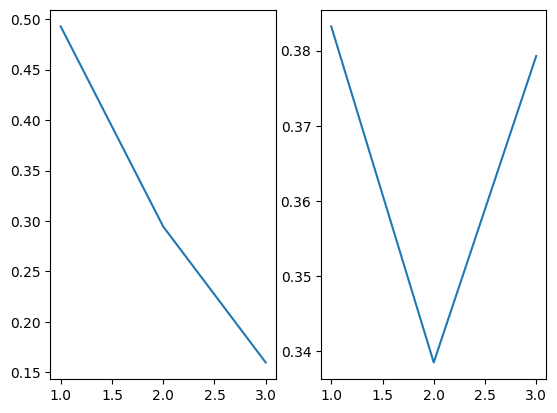

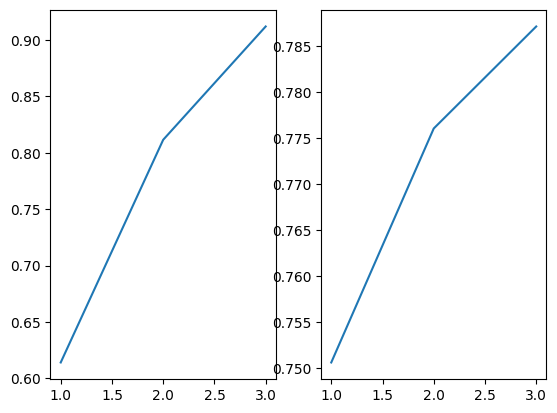

In [27]:
loss_acc_plot(loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val)

In [28]:
predictions, true_labels = test_model()

    DONE.


In [29]:
classification_report_(predictions, true_labels)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       528
           1       0.83      0.80      0.81       508
           2       0.71      0.77      0.74       500

    accuracy                           0.81      1536
   macro avg       0.81      0.81      0.81      1536
weighted avg       0.81      0.81      0.81      1536



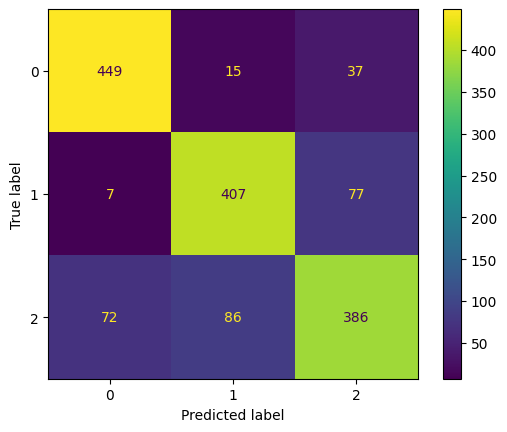

In [30]:
confusion_matrix_(true_labels, predictions)

#Section 2-3 / Freezing first 9 layers

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


print(model.bert)

# Tell pytorch to run this model on the GPU.
# model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [32]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 0.00006,
                  eps = 1e-8
                )
epochs = 3

total_steps = len(train_dl) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [33]:
for param in model.bert.encoder.layer[:9].parameters():
    param.requires_grad = False

In [34]:
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

bert.embeddings.word_embeddings.weight: True
bert.embeddings.position_embeddings.weight: True
bert.embeddings.token_type_embeddings.weight: True
bert.embeddings.LayerNorm.weight: True
bert.embeddings.LayerNorm.bias: True
bert.encoder.layer.0.attention.self.query.weight: False
bert.encoder.layer.0.attention.self.query.bias: False
bert.encoder.layer.0.attention.self.key.weight: False
bert.encoder.layer.0.attention.self.key.bias: False
bert.encoder.layer.0.attention.self.value.weight: False
bert.encoder.layer.0.attention.self.value.bias: False
bert.encoder.layer.0.attention.output.dense.weight: False
bert.encoder.layer.0.attention.output.dense.bias: False
bert.encoder.layer.0.attention.output.LayerNorm.weight: False
bert.encoder.layer.0.attention.output.LayerNorm.bias: False
bert.encoder.layer.0.intermediate.dense.weight: False
bert.encoder.layer.0.intermediate.dense.bias: False
bert.encoder.layer.0.output.dense.weight: False
bert.encoder.layer.0.output.dense.bias: False
bert.encoder.laye

In [35]:
loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val = train_model()


======== Epoch 1 / 3 ========
Training...
loss: 0.769339919090271
loss: 0.6855306625366211
loss: 0.6398863792419434
loss: 0.6121307611465454
loss: 0.6627594828605652
loss: 0.7225661277770996
loss: 0.7120832800865173
loss: 0.6522301435470581
loss: 0.6724907755851746
loss: 0.6443876624107361
loss: 0.6474716663360596
loss: 0.6424417495727539
loss: 0.6093253493309021
loss: 0.6196043491363525
loss: 0.6362746953964233
loss: 0.6356953978538513
loss: 0.6343124508857727
loss: 0.6434791088104248
loss: 0.6386561393737793
loss: 0.6470410823822021
loss: 0.6168616414070129
loss: 0.6252018213272095
loss: 0.622551441192627
loss: 0.6099258065223694
loss: 0.6481637954711914
loss: 0.6841735243797302
loss: 0.6675039529800415
loss: 0.6312146186828613
loss: 0.6652623414993286
loss: 0.6247854232788086
loss: 0.5904863476753235
loss: 0.5868847370147705
loss: 0.630467414855957
loss: 0.6204871535301208
loss: 0.6681410074234009
loss: 0.6480071544647217
loss: 0.5771055817604065
loss: 0.621902346611023
loss: 0.566

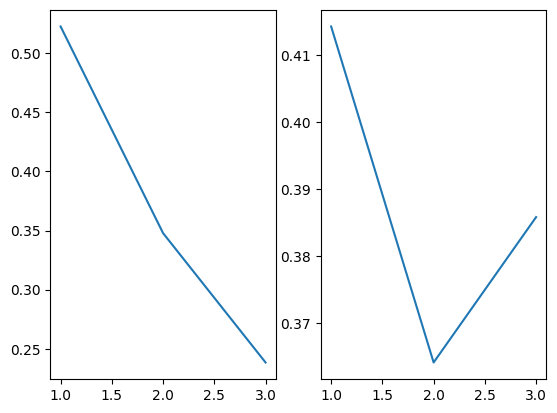

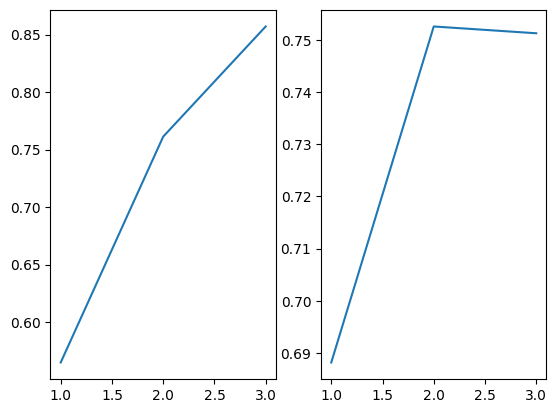

In [36]:
loss_acc_plot(loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val)

In [37]:
predictions, true_labels = test_model()

    DONE.


In [38]:
classification_report_(predictions, true_labels)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       528
           1       0.74      0.82      0.78       508
           2       0.69      0.67      0.68       500

    accuracy                           0.77      1536
   macro avg       0.77      0.77      0.77      1536
weighted avg       0.77      0.77      0.77      1536



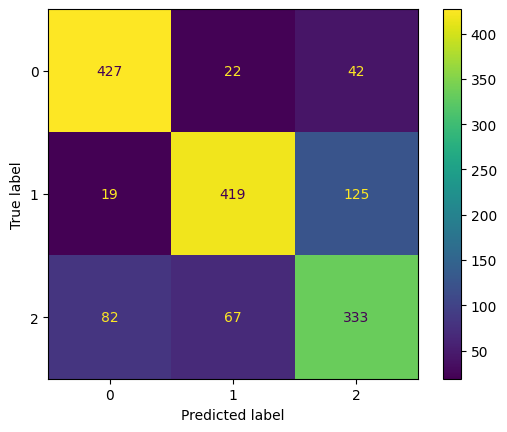

In [39]:
confusion_matrix_(true_labels, predictions)

#Section 2-3 / Freezing All layers except last one and embedding

In [40]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


print(model.bert)

# Tell pytorch to run this model on the GPU.
# model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [41]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 0.00006,
                  eps = 1e-8
                )
epochs = 3

total_steps = len(train_dl) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [42]:
from transformers import BertModel, BertConfig
import torch

# Freeze all layers except the last layer and the embedding layer
for name, param in model.named_parameters():
    if 'embedding' in name or 'encoder.layer.11' in name:  # 'encoder.layer.11' corresponds to the last layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Check which layers are frozen
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')


bert.embeddings.word_embeddings.weight: True
bert.embeddings.position_embeddings.weight: True
bert.embeddings.token_type_embeddings.weight: True
bert.embeddings.LayerNorm.weight: True
bert.embeddings.LayerNorm.bias: True
bert.encoder.layer.0.attention.self.query.weight: False
bert.encoder.layer.0.attention.self.query.bias: False
bert.encoder.layer.0.attention.self.key.weight: False
bert.encoder.layer.0.attention.self.key.bias: False
bert.encoder.layer.0.attention.self.value.weight: False
bert.encoder.layer.0.attention.self.value.bias: False
bert.encoder.layer.0.attention.output.dense.weight: False
bert.encoder.layer.0.attention.output.dense.bias: False
bert.encoder.layer.0.attention.output.LayerNorm.weight: False
bert.encoder.layer.0.attention.output.LayerNorm.bias: False
bert.encoder.layer.0.intermediate.dense.weight: False
bert.encoder.layer.0.intermediate.dense.bias: False
bert.encoder.layer.0.output.dense.weight: False
bert.encoder.layer.0.output.dense.bias: False
bert.encoder.laye

In [43]:
loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val = train_model()


======== Epoch 1 / 3 ========
Training...
loss: 0.769339919090271
loss: 0.7222973108291626
loss: 0.7357523441314697
loss: 0.6836442947387695
loss: 0.6749780178070068
loss: 0.6502276659011841
loss: 0.6602327227592468
loss: 0.6421107053756714
loss: 0.6485303640365601
loss: 0.632745087146759
loss: 0.6527789831161499
loss: 0.6351854205131531
loss: 0.6171165704727173
loss: 0.6253211498260498
loss: 0.6389994025230408
loss: 0.6480407118797302
loss: 0.651289701461792
loss: 0.6492809653282166
loss: 0.6389345526695251
loss: 0.6522724628448486
loss: 0.6403588056564331
loss: 0.6300144195556641
loss: 0.6425843238830566
loss: 0.641426682472229
loss: 0.6329178810119629
loss: 0.6595208644866943
loss: 0.6565761566162109
loss: 0.6371855735778809
loss: 0.6398801803588867
loss: 0.6379326581954956
loss: 0.6188693046569824
loss: 0.6213917136192322
loss: 0.6397348642349243
loss: 0.6505090594291687
loss: 0.6574581861495972
loss: 0.6268627643585205
loss: 0.6260876655578613
loss: 0.6376044750213623
loss: 0.628

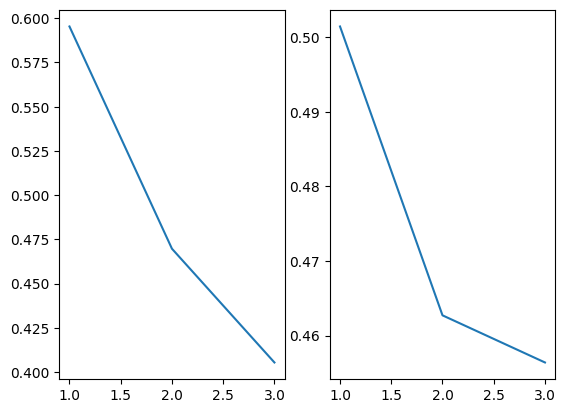

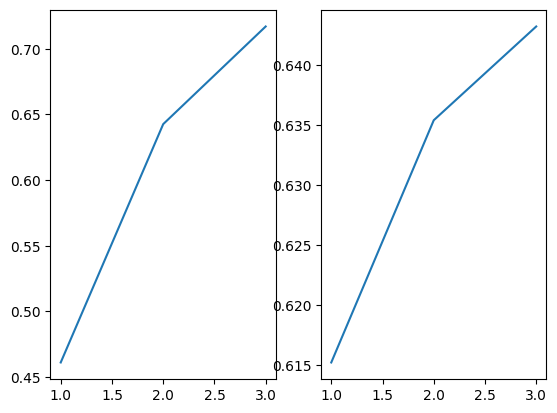

In [44]:
loss_acc_plot(loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val)

In [45]:
predictions, true_labels = test_model()

    DONE.


In [46]:
classification_report_(predictions, true_labels)

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       528
           1       0.60      0.79      0.68       508
           2       0.54      0.35      0.42       500

    accuracy                           0.66      1536
   macro avg       0.65      0.65      0.64      1536
weighted avg       0.65      0.66      0.64      1536



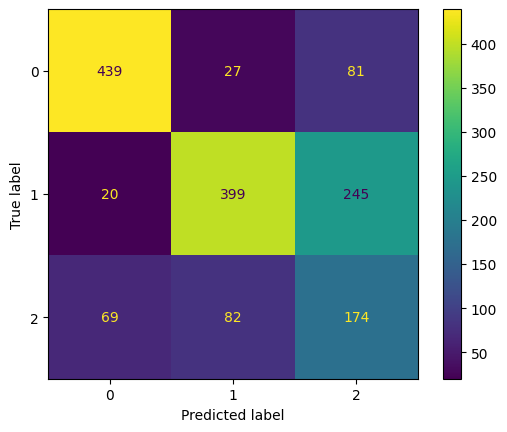

In [47]:
confusion_matrix_(true_labels, predictions)

#Section 2-4 / Removing all layers except first 9 layers

In [48]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


print(model.bert)

# Tell pytorch to run this model on the GPU.
# model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [49]:
model.bert.encoder.layer = model.bert.encoder.layer[:9]

# Update the config to reflect the new number of layers
model.config.num_hidden_layers = 9

In [50]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 0.00006,
                  eps = 1e-8
                )
epochs = 3

total_steps = len(train_dl) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [51]:
# from transformers import BertModel, BertConfig
# import torch

# for param in model.parameters():
#     param.requires_grad = False

# for param in model.bert.encoder.layer[:9].parameters():
#     param.requires_grad = True

# # Check which layers are frozen
# for name, param in model.named_parameters():
#     print(f'{name}: {param.requires_grad}')


In [52]:
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

bert.embeddings.word_embeddings.weight: True
bert.embeddings.position_embeddings.weight: True
bert.embeddings.token_type_embeddings.weight: True
bert.embeddings.LayerNorm.weight: True
bert.embeddings.LayerNorm.bias: True
bert.encoder.layer.0.attention.self.query.weight: True
bert.encoder.layer.0.attention.self.query.bias: True
bert.encoder.layer.0.attention.self.key.weight: True
bert.encoder.layer.0.attention.self.key.bias: True
bert.encoder.layer.0.attention.self.value.weight: True
bert.encoder.layer.0.attention.self.value.bias: True
bert.encoder.layer.0.attention.output.dense.weight: True
bert.encoder.layer.0.attention.output.dense.bias: True
bert.encoder.layer.0.attention.output.LayerNorm.weight: True
bert.encoder.layer.0.attention.output.LayerNorm.bias: True
bert.encoder.layer.0.intermediate.dense.weight: True
bert.encoder.layer.0.intermediate.dense.bias: True
bert.encoder.layer.0.output.dense.weight: True
bert.encoder.layer.0.output.dense.bias: True
bert.encoder.layer.0.output.Lay

In [53]:
loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val = train_model()


======== Epoch 1 / 3 ========
Training...
loss: 0.7944430112838745
loss: 0.6546175479888916
loss: 0.5931887030601501
loss: 0.6189203262329102
loss: 0.6880121231079102
loss: 0.7856202125549316
loss: 0.754706859588623
loss: 0.6337502002716064
loss: 0.6669652462005615
loss: 0.6584599018096924
loss: 0.6461591124534607
loss: 0.6674212217330933
loss: 0.6405798196792603
loss: 0.6264328956604004
loss: 0.6274840831756592
loss: 0.6398077011108398
loss: 0.6274195313453674
loss: 0.6134697198867798
loss: 0.6393076181411743
loss: 0.6038954257965088
loss: 0.5794333219528198
loss: 0.5665326118469238
loss: 0.5748018026351929
loss: 0.5638682246208191
loss: 0.6086159348487854
loss: 0.610508382320404
loss: 0.5294413566589355
loss: 0.5667557716369629
loss: 0.5219215154647827
loss: 0.5416172742843628
loss: 0.6231204867362976
loss: 0.6317336559295654
loss: 0.570223867893219
loss: 0.49649107456207275
loss: 0.5521971583366394
loss: 0.5650117993354797
loss: 0.5277363061904907
loss: 0.5288659334182739
loss: 0.5

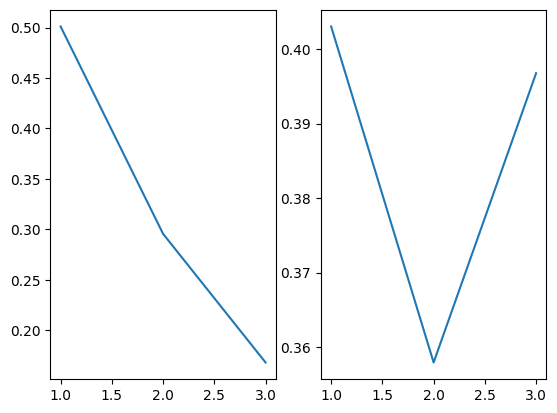

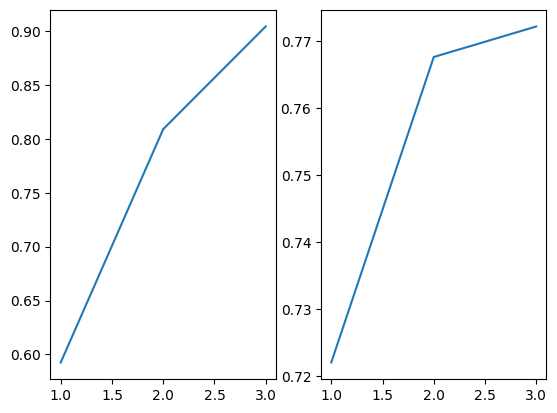

In [54]:
loss_acc_plot(loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val)

In [55]:
predictions, true_labels = test_model()

    DONE.


In [56]:
classification_report_(predictions, true_labels)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       528
           1       0.79      0.81      0.80       508
           2       0.71      0.70      0.70       500

    accuracy                           0.79      1536
   macro avg       0.79      0.79      0.79      1536
weighted avg       0.79      0.79      0.79      1536



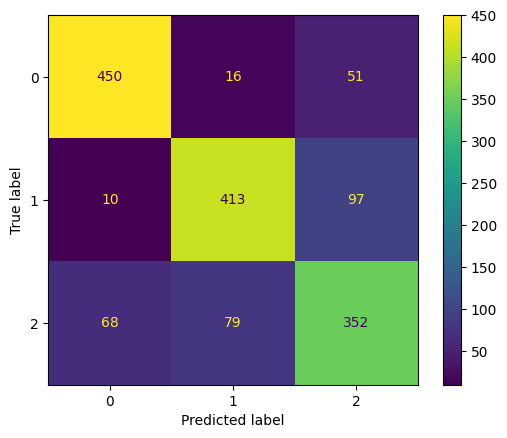

In [57]:
confusion_matrix_(true_labels, predictions)

#Section 2-5 / Pruning Attention heads

In [111]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

def prune_heads(model, layer_idx, heads_to_prune):
    model.bert.encoder.layer[layer_idx].attention.prune_heads(heads_to_prune)

num_heads_to_prune = int(0.5 * model.config.num_attention_heads)
prune_heads(model, layer_idx=0, heads_to_prune=list(range(num_heads_to_prune)))

print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=384, bias=True)
              (key): Linear(in_features=768, out_features=384, bias=True)
              (value): Linear(in_features=768, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [112]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 0.00006,
                  eps = 1e-8
                )
epochs = 3

total_steps = len(train_dl) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [113]:
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

bert.embeddings.word_embeddings.weight: True
bert.embeddings.position_embeddings.weight: True
bert.embeddings.token_type_embeddings.weight: True
bert.embeddings.LayerNorm.weight: True
bert.embeddings.LayerNorm.bias: True
bert.encoder.layer.0.attention.self.query.weight: True
bert.encoder.layer.0.attention.self.query.bias: True
bert.encoder.layer.0.attention.self.key.weight: True
bert.encoder.layer.0.attention.self.key.bias: True
bert.encoder.layer.0.attention.self.value.weight: True
bert.encoder.layer.0.attention.self.value.bias: True
bert.encoder.layer.0.attention.output.dense.weight: True
bert.encoder.layer.0.attention.output.dense.bias: True
bert.encoder.layer.0.attention.output.LayerNorm.weight: True
bert.encoder.layer.0.attention.output.LayerNorm.bias: True
bert.encoder.layer.0.intermediate.dense.weight: True
bert.encoder.layer.0.intermediate.dense.bias: True
bert.encoder.layer.0.output.dense.weight: True
bert.encoder.layer.0.output.dense.bias: True
bert.encoder.layer.0.output.Lay

In [114]:
loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val = train_model()


======== Epoch 1 / 3 ========
Training...
loss: 0.6946651339530945
loss: 0.678331732749939
loss: 0.6010633707046509
loss: 0.5955610275268555
loss: 0.6594570279121399
loss: 0.7311999201774597
loss: 0.7020276784896851
loss: 0.6158946752548218
loss: 0.6529026031494141
loss: 0.6374448537826538
loss: 0.6432094573974609
loss: 0.6342271566390991
loss: 0.6222032904624939
loss: 0.6005344390869141
loss: 0.5913934707641602
loss: 0.5552433729171753
loss: 0.5460666418075562
loss: 0.5318275094032288
loss: 0.518136739730835
loss: 0.5681620836257935
loss: 0.6026067733764648
loss: 0.635999858379364
loss: 0.5851091742515564
loss: 0.5254535675048828
loss: 0.5332090854644775
loss: 0.6509559154510498
loss: 0.46038293838500977
loss: 0.5878263115882874
loss: 0.4934714436531067
loss: 0.6061146259307861
loss: 0.6337015628814697
loss: 0.6438926458358765
loss: 0.5618619322776794
loss: 0.5447797179222107
loss: 0.5381135940551758
loss: 0.5620189905166626
loss: 0.5241172313690186
loss: 0.514746904373169
loss: 0.51

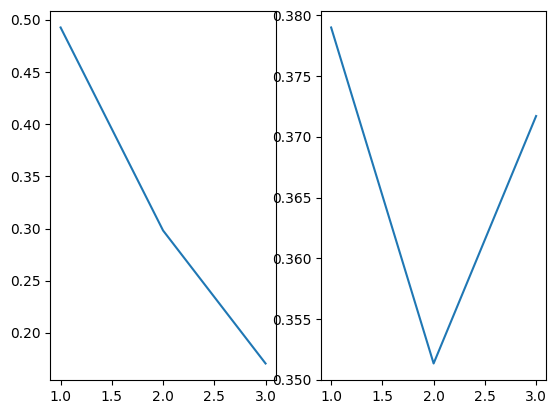

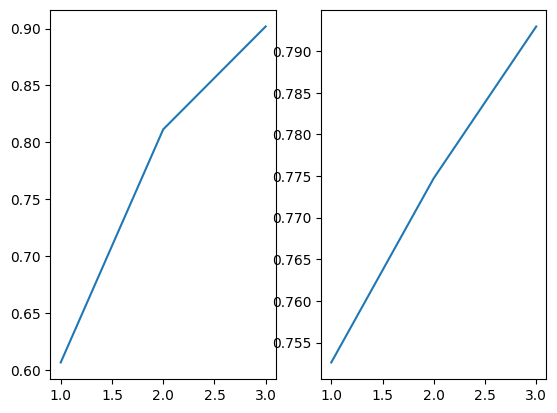

In [115]:
loss_acc_plot(loss_arr_train, loss_arr_val, acc_arr_train, acc_arr_val)

In [116]:
predictions, true_labels = test_model()

    DONE.


In [117]:
classification_report_(predictions, true_labels)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       528
           1       0.82      0.79      0.80       508
           2       0.70      0.74      0.72       500

    accuracy                           0.80      1536
   macro avg       0.80      0.80      0.80      1536
weighted avg       0.80      0.80      0.80      1536



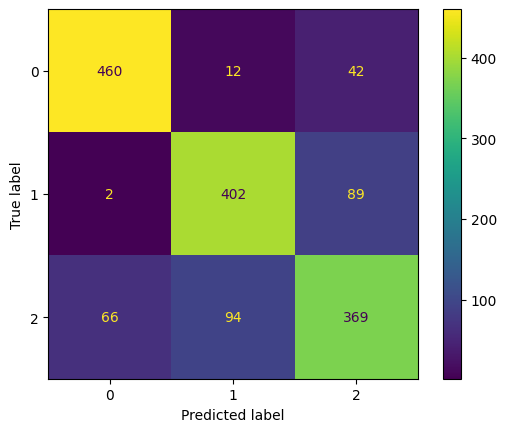

In [118]:
confusion_matrix_(true_labels, predictions)